In [1]:
from google.colab import files
import zipfile
import os

# Step 1: Upload the ZIP file to Colab
print("Please upload your ZIP file...")
uploaded = files.upload()  # This will prompt you to upload the file

# Step 2: Extract the ZIP file
zip_file_name = list(uploaded.keys())[0]  # Get the uploaded file name
extract_dir = "/content/cifake_dataset"  # Define the extraction directory

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

# Step 3: Check extracted directories
train_dir = os.path.join(extract_dir, "train")
test_dir = os.path.join(extract_dir, "test")

print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")


Please upload your ZIP file...


Saving archive (3).zip to archive (3).zip
Dataset extracted to /content/cifake_dataset
Train directory exists: True
Test directory exists: True


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset information
print(f"Train dataset loaded with {len(train_dataset)} samples.")
print(f"Test dataset loaded with {len(test_dataset)} samples.")


Train dataset loaded with 100000 samples.
Test dataset loaded with 20000 samples.


In [4]:
from torchvision import models
from torch import nn

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # Adjust for the number of classes
model = model.to(device)

print("Model ready and moved to device.")


Using device: cuda
Model ready and moved to device.


In [5]:
from torch import optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training loop with early stopping
num_epochs = 50
patience = 5  # Early stopping patience
best_val_acc = 0
epochs_no_improve = 0

train_accs, val_accs = [], []

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_accs.append(train_acc)
    print(f"Epoch {epoch+1}, Train Accuracy: {train_acc:.2f}%")

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "best_resnet18_cifake.pth")
        print(f"New best model saved with Validation Accuracy: {val_acc:.2f}%")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

print("Training complete.")


Starting training...


Epoch 1/50 (Training): 100%|██████████| 1563/1563 [03:27<00:00,  7.54it/s]


Epoch 1, Train Accuracy: 93.72%
Epoch 1, Validation Accuracy: 95.78%
New best model saved with Validation Accuracy: 95.78%


Epoch 2/50 (Training): 100%|██████████| 1563/1563 [03:24<00:00,  7.63it/s]


Epoch 2, Train Accuracy: 95.89%
Epoch 2, Validation Accuracy: 96.01%
New best model saved with Validation Accuracy: 96.01%


Epoch 3/50 (Training): 100%|██████████| 1563/1563 [03:24<00:00,  7.63it/s]


Epoch 3, Train Accuracy: 96.66%
Epoch 3, Validation Accuracy: 96.66%
New best model saved with Validation Accuracy: 96.66%


Epoch 4/50 (Training): 100%|██████████| 1563/1563 [03:24<00:00,  7.64it/s]


Epoch 4, Train Accuracy: 97.33%


Epoch 5/50 (Training): 100%|██████████| 1563/1563 [03:24<00:00,  7.64it/s]


Epoch 5, Train Accuracy: 97.81%
Epoch 5, Validation Accuracy: 97.14%
New best model saved with Validation Accuracy: 97.14%


Epoch 6/50 (Training): 100%|██████████| 1563/1563 [03:23<00:00,  7.68it/s]


Epoch 6, Train Accuracy: 98.41%
Epoch 6, Validation Accuracy: 97.46%
New best model saved with Validation Accuracy: 97.46%


Epoch 7/50 (Training): 100%|██████████| 1563/1563 [03:25<00:00,  7.62it/s]


Epoch 7, Train Accuracy: 98.66%
Epoch 7, Validation Accuracy: 97.03%


Epoch 8/50 (Training): 100%|██████████| 1563/1563 [03:22<00:00,  7.70it/s]


Epoch 8, Train Accuracy: 98.99%
Epoch 8, Validation Accuracy: 97.03%


Epoch 9/50 (Training): 100%|██████████| 1563/1563 [03:24<00:00,  7.66it/s]


Epoch 9, Train Accuracy: 99.17%
Epoch 9, Validation Accuracy: 96.92%


Epoch 10/50 (Training): 100%|██████████| 1563/1563 [03:25<00:00,  7.61it/s]


Epoch 10, Train Accuracy: 99.28%
Epoch 10, Validation Accuracy: 97.22%


Epoch 11/50 (Training): 100%|██████████| 1563/1563 [03:24<00:00,  7.64it/s]


Epoch 11, Train Accuracy: 99.37%
Epoch 11, Validation Accuracy: 97.22%
Early stopping triggered at epoch 11.
Training complete.


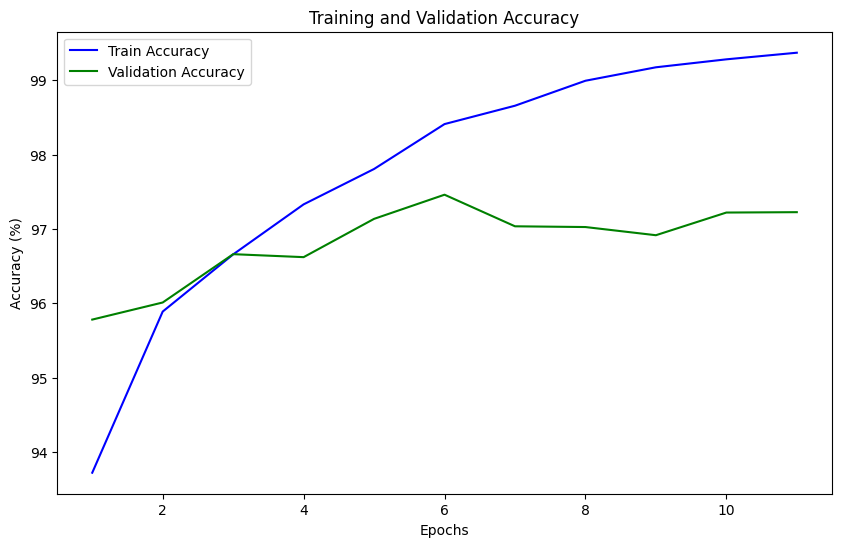

In [7]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy", color='blue')
plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


In [8]:
import pickle

# Save the trained model
pkl_filename = "resnet18_cifake.pkl"

with open(pkl_filename, 'wb') as pkl_file:
    pickle.dump(model, pkl_file)

print(f"Model saved as '{pkl_filename}'.")

from google.colab import files

files.download("resnet18_cifake.pkl")


Model saved as 'resnet18_cifake.pkl'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>